In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

import cProfile
profiler = cProfile.Profile()

# Get 3D aPSF-kernel

## Numpy CPU single-core implementation 

100%|██████████| 4630/4630 [00:54<00:00, 84.76it/s]


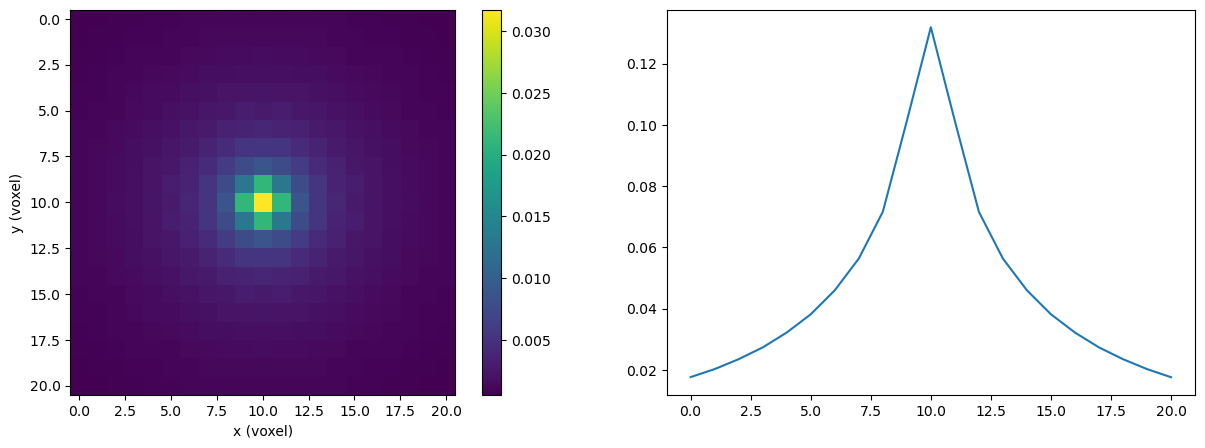

In [ ]:
def aPSF3D_sb(_r, _a, _b, _c, _n):
    eps = 1e-4 #mm
    _r = np.where(_r < eps, eps, _r)

    f = (_a*_r)**_n + (_b*_r)**2.5 + (_c*_r)**3.5
    df = (_n*_a*(_a*_r)**(_n-1) + 2.5*_b*(_b*_r)**1.5 + 3.5*_c*(_c*_r)**2.5)

    aPSF3D = df * np.exp(-f) / _r**2
    return aPSF3D

def VG(dist_aPSF3D, STEP, SIZE, rlim, voxel_griding=10, source_griding=11):
    """
    Performs voxel gridding (VG) to compute a 3D PSF kernel.

    Parameters:
        dist_aPSF3D (function): Function that calculates the PSF value given a distance r
        STEP (list): Voxel dimensions in mm [dx, dy, dz]
        SIZE (list): Kernel size in voxels [nx, ny, nz]
        rlim (tuple): (rmin, rmax) Range of distances to consider in mm
        voxel_griding (int): Number of samples within each voxel
        source_griding (int): Number of samples within the source voxel

    Returns:
        numpy.ndarray: Normalized 3D PSF kernel
    """
    if voxel_griding % 2 == 0:
        voxel_griding += 1  # Ensure voxel_griding is odd
        print("voxel_griding is changed to", voxel_griding)

    rmin, rmax = rlim
    rmin = max(rmin, 1e-6)  # Ensure rmin is not zero
    RMAX = 3**0.5 * max(STEP)*max(SIZE)/2
    rmax = RMAX if rmax is None or rmax > RMAX else rmax    # Ensure rmax is within reasonable bounds

    dx, dy, dz = STEP
    nx, ny, nz = SIZE
    aPSF_kernel = np.zeros((nx, ny, nz), dtype=np.float32)

    # Check size is odd
    if nx % 2 == 0 or ny % 2 == 0 or nz % 2 == 0:
        raise ValueError("Kernel sizes must be odd to properly place the source voxel.")

    # Load iterators to save memory
    voxel_indices = itertools.product(range(nx), range(ny), range(nz))
    voxel_centers = itertools.starmap(lambda ix, iy, iz: ((ix-nx//2)*dx, (iy-ny//2)*dy, (iz-nz//2)*dz), voxel_indices)

    # Grid points in source voxel
    grid_source = [np.linspace(0, step/2, 1+source_griding//2) for step in STEP]  # Only positive to always start at 0
    grid_source = [np.sort(np.concat((-g[1:], +g), dtype=np.float32)) for g in grid_source]         # Include negative values

    # Loop over all voxels in kernel and grid them
    for (ix,iy,iz), (cx,cy,cz) in tqdm(zip(voxel_indices, voxel_centers), total=nx*ny*nz//2):
      grid_xyz = np.linspace((cx-dx/2, cy-dy/2, cz-dz/2), (cx+dx/2, cy+dy/2, cz+dz/2), voxel_griding)
      x,y,z = np.meshgrid(grid_xyz[:, 0], grid_xyz[:, 1], grid_xyz[:, 2], indexing='ij')

      # Loop over all sampled source points and eval aPSF3D(r)
      for (sx, sy, sz) in itertools.product(*grid_source):
        r = np.sqrt((x-sx)**2 + (y-sy)**2 + (z-sz)**2)
        mask = (r >= rmin) & (r <= rmax)
        psf = dist_aPSF3D(r) * mask
        aPSF_kernel[ix, iy, iz] += psf.sum()

    aPSF_kernel /= aPSF_kernel.sum()    
    return aPSF_kernel

a,b,c,n = 0.312,  0.233,  0.121,  1.106
aPSF3D = lambda r: aPSF3D_sb(r, a, b, c, n)


SIZE = [21]*3  # kernel size
STEP = [0.1]*3  # voxel size in mm
aPSF_kernel_VG = VG(aPSF3D, STEP, SIZE, rlim=(5e-6, 2), voxel_griding=13, source_griding=5)
# aPSF_kernel_VG[aPSF_kernel_VG > 3e-3] = 3e-3

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(np.sum(aPSF_kernel_VG, axis=2))
plt.xlabel("x (voxel)")
plt.ylabel("y (voxel)")
plt.colorbar()

plt.subplot(122)
plt.plot(np.sum(aPSF_kernel_VG, axis=(1, 2)))
plt.show()

## PyTorch GPU implementation

In [39]:
import torch


def aPSF3D_sb(_r, _a, _b, _c, _n):
    eps = 1e-4 #mm
    _r = torch.where(_r < eps, eps, _r)

    f = (_a*_r)**_n + (_b*_r)**2.5 + (_c*_r)**3.5
    df = (_n*_a*(_a*_r)**(_n-1) + 2.5*_b*(_b*_r)**1.5 + 3.5*_c*(_c*_r)**2.5)

    aPSF3D = df * torch.exp(-f) / _r**2
    return aPSF3D

def VG(dist_aPSF3D, STEP, SIZE, rlim, voxel_griding=11, source_griding=1):
    """ dist(r), STEP and rlim in mm """
    if voxel_griding % 2 == 0:
        voxel_griding += 1  # Ensure voxel_griding is odd
        print("voxel_griding is changed to", voxel_griding)

    rmin, rmax = rlim
    rmin = max(rmin, 1e-6)  # Ensure rmin is not zero
    RMAX = 3**0.5 * max(STEP)*max(SIZE)/2
    rmax = RMAX if rmax is None or rmax > RMAX else rmax    # Ensure rmax is within reasonable bounds 
    dx, dy, dz = STEP
    nx, ny, nz = SIZE
    aPSF_kernel = torch.zeros((nx, ny, nz)).to(device)

    # Check size is odd
    if nx % 2 == 0 or ny % 2 == 0 or nz % 2 == 0:
        raise ValueError("Kernel sizes must be odd to properly place the source voxel.")

    # Sample a full 3D grid of points within the center voxel
    voxel_indices = itertools.product(range(nx), range(ny), range(nz))
    voxel_centers = itertools.starmap(lambda ix, iy, iz: ((ix-nx//2)*dx, (iy-ny//2)*dy, (iz-nz//2)*dz), voxel_indices)

    grid_source = [np.linspace(0, step/2, 1+source_griding//2) for step in STEP]  # Only positive to always start at 0
    grid_source = [np.sort(np.concat((-g[1:], +g))) for g in grid_source]         # Include negative values

    for (ix,iy,iz), (cx,cy,cz) in tqdm(zip(voxel_indices, voxel_centers), total=nx*ny*nz//2):
      x = torch.linspace(cx-dx/2, cx+dx/2, voxel_griding)
      y = torch.linspace(cy-dy/2, cy+dy/2, voxel_griding)
      z = torch.linspace(cz-dz/2, cz+dz/2, voxel_griding)
      xx,yy,zz = torch.meshgrid(x, y, z, indexing='ij')

      for (sx, sy, sz) in itertools.product(*grid_source):
        r = torch.sqrt((xx-sx)**2 + (yy-sy)**2 + (zz-sz)**2).to(device)
        mask = (r >= rmin) & (r <= rmax)
        psf = dist_aPSF3D(r) * mask
        aPSF_kernel[ix, iy, iz] += psf.sum()

    aPSF_kernel /= aPSF_kernel.sum()    
    return aPSF_kernel

a,b,c,n = 0.312,  0.233,  0.121,  1.106
aPSF3D = lambda r: aPSF3D_sb(r, a, b, c, n)


SIZE = [21]*3  # kernel size
STEP = [0.1]*3  # voxel size in mm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
profiler.enable()
aPSF_kernel_VG = VG(aPSF3D, STEP, SIZE, rlim=(1e-6, 2), voxel_griding=13, source_griding=5)
profiler.disable()
# profiler.print_stats(sort='tottime')
aPSF_kernel_VG = aPSF_kernel_VG.cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(np.sum(aPSF_kernel_VG, axis=2))
plt.xlabel("x (voxel)")
plt.ylabel("y (voxel)")
plt.colorbar()

plt.subplot(122)
plt.plot(np.sum(aPSF_kernel_VG, axis=(1, 2)))
plt.show()

ModuleNotFoundError: No module named 'torch'

# Compare with kernel from simulation